<a href="https://colab.research.google.com/github/Collin-Campbell/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [31]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [60]:
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

In [61]:
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv')).set_index('id')
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv').set_index('id')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv').set_index('id')

train.shape, test.shape

((59400, 40), (14358, 39))

In [62]:
def wrangle(X):
  # Make a copy
  X = X.copy()

  # Drop high cardinality cols
  high_card_cols = [col for col in X.select_dtypes('object').columns
                    if X[col].nunique() > 100]

  X.drop(columns=high_card_cols, inplace=True)
  
  # Drop repeated columns (kept ones with most data if small discrepancy)
  cols = ['quantity', 'waterpoint_type_group', 'source_type', 'payment_type', 'management_group', 
        'extraction_type_class', 'extraction_type_group']

  X.drop(columns=cols, inplace=True)

  # Filled null values with "None"
  X['scheme_management'].fillna('None', inplace=True)


  if 'status_group' in X:
  # Create binary target
    X['needs_repair'] = X['status_group'].replace({'functional':0, 
                                                  'non functional':1, 
                                                  'functional needs repair':1})
    X.drop(columns='status_group', inplace=True)
  
  X['latitude'] = X['latitude'].replace(-2e-08, np.nan)

  cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
  for col in cols_with_zeros:
      X[col] = X[col].replace(0, np.nan)

  return X

In [63]:
# applying wrangle function to training set

train = wrangle(train)

In [64]:
print(train.shape)
train.head()

(59400, 25)


,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,public_meeting,recorded_by,scheme_management,permit,construction_year,extraction_type,management,payment,water_quality,quality_group,quantity_group,source,source_class,waterpoint_type,needs_repair
id,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,1390.0,34.938093,-9.856322,0,Lake Nyasa,Iringa,11,5,109.0,True,GeoData Consultants Ltd,VWC,False,1999.0,gravity,vwc,pay annually,soft,good,enough,spring,groundwater,communal standpipe,0
8776,0.0,1399.0,34.698766,-2.147466,0,Lake Victoria,Mara,20,2,280.0,NaN,GeoData Consultants Ltd,Other,True,2010.0,gravity,wug,never pay,soft,good,insufficient,rainwater harvesting,surface,communal standpipe,0
34310,25.0,686.0,37.460664,-3.821329,0,Pangani,Manyara,21,4,250.0,True,GeoData Consultants Ltd,VWC,True,2009.0,gravity,vwc,pay per bucket,soft,good,enough,dam,surface,communal standpipe multiple,0
67743,0.0,263.0,38.486161,-11.155298,0,Ruvuma / Southern Coast,Mtwara,90,63,58.0,True,GeoData Consultants Ltd,VWC,True,1986.0,submersible,vwc,never pay,soft,good,dry,machine dbh,groundwater,communal standpipe multiple,1
19728,0.0,NaN,31.130847,-1.825359,0,Lake Victoria,Kagera,18,1,NaN,True,GeoData Consultants Ltd,None,True,NaN,gravity,other,never pay,soft,good,seasonal,rainwater harvesting,surface,communal standpipe,0


In [65]:
print(train.shape)
train['needs_repair'].head()

# 1 means 'needs repair'

(59400, 25)


id
69572    0
8776     0
34310    0
67743    1
19728    0
Name: needs_repair, dtype: int64

In [66]:
target = 'needs_repair'

# split target and feature matrix

y = train[target]
X = train.drop(columns=target)

In [67]:
# splitting training into 80% train and 20% val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Sanity check
assert len(X_train) + len(X_val) == len(X)

In [68]:
# Establishing baseline (classification so majority class)

print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5429713804713805


In [69]:
# majority class is 0, which is does not need repair

y_train.value_counts(normalize=True)

0    0.542971
1    0.457029
Name: needs_repair, dtype: float64

In [70]:
# building model pipeline

forest_model = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(),
      RandomForestClassifier(n_estimators=150,
                            random_state=42,
                            n_jobs=-1, criterion='entropy', max_depth=19, max_samples=0.5
      ))

In [71]:
# fitting model on training set
forest_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'recorded_by', 'scheme_management',
                                      'permit', 'extraction_type', 'management',
                                      'payment', 'water_quality',
                                      'quality_group', 'quantity_group',
                                      'source', 'source_class',
                                      'waterpoint_type'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mappin...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='entropy',
                                        max_depth=19, max_features='auto',
                                        max_leaf_n

In [72]:
# checking metrics (accuracy)

print('FOREST: Training Accuracy:', forest_model.score(X_train, y_train))
print('FOREST: Validation Accuracy:', forest_model.score(X_val, y_val))

FOREST: Training Accuracy: 0.9078914141414142
FOREST: Validation Accuracy: 0.825925925925926


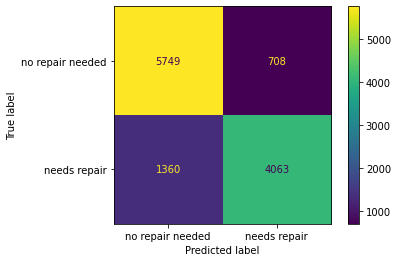

In [73]:
# checking metrics (confusion matrix)

plot_confusion_matrix(forest_model, X_val, y_val, # <-- Using validation data
                      values_format='.0f',
                      display_labels=['no repair needed', 'needs repair']);

In [74]:
# RECALL
# Of those pumps that actually needed repair,
# what proportion did you correctly predict as needing repair?
print('Recall:', 4063 / (4063 + 1360))

Recall: 0.7492163009404389


In [75]:
# PRECISION
# Of all the pumps that you predicted as needing repair,
# what proportion actually needed repair?
print('Precision:', 4063 / (4063 + 708))

Precision: 0.8516034374345001


In [76]:
print(classification_report(y_val, forest_model.predict(X_val)))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85      6457
           1       0.85      0.75      0.80      5423

    accuracy                           0.83     11880
   macro avg       0.83      0.82      0.82     11880
weighted avg       0.83      0.83      0.82     11880



In [77]:
# creating Kaggle submission

X_test = wrangle(test)

In [78]:
y_pred = forest_model.predict(X_test)
submission = pd.DataFrame({'status_group':y_pred}, index=X_test.index)

submission.head()

,status_group
id,
50785,1
51630,0
17168,0
45559,1
49871,0


In [79]:
assert len(submission) == 14358

In [52]:
submission.to_csv('submission.csv')